In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

['.ipynb_checkpoints', 'Data_Entry_2017.csv', 'pneumonia_predict.ipynb', 'predict.py', 'sample_labels.csv', 'Untitled.ipynb']
Scans found: 22120 , Total Headers 112120
label_counts:  No Finding                  12239
Infiltration                 1797
Atelectasis                   806
Effusion                      749
Nodule                        573
Pneumothorax                  423
Mass                          357
Cardiomegaly                  336
Consolidation                 284
Effusion|Infiltration         265
Atelectasis|Infiltration      234
Pleural_Thickening            219
Atelectasis|Effusion          211
Fibrosis                      198
Emphysema                     186
Name: Finding Labels, dtype: int64


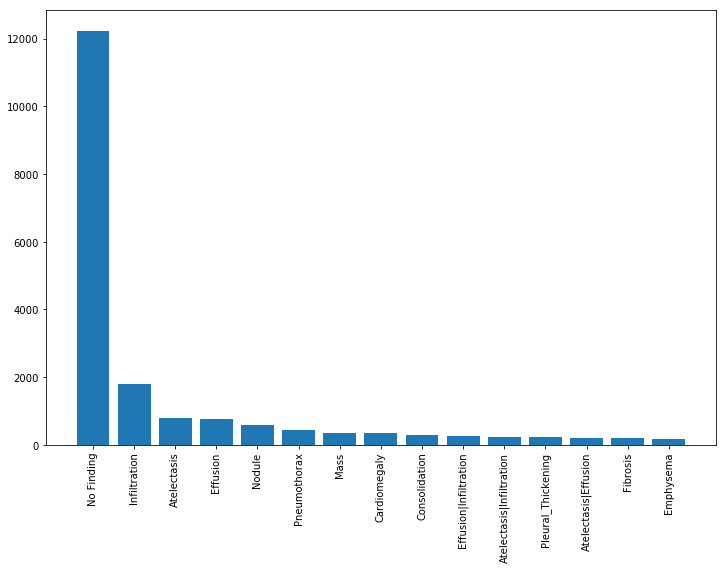

In [2]:

print(os.listdir())
all_xray_df = pd.read_csv(r'Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('D:', 'Theano', 'Chest_XRay', 'xray_images', 'xray_images_*', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
#print(all_xray_df.sample(3))

#all_xray_df = all_xray_df.loc[:, ['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender','View Position',OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]]]

all_xray_df = all_xray_df.dropna() 

#print("After Drop: ", all_xray_df.sample(10))


#PReprocessing Labels
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)
plt.show

print("label_counts: ", label_counts)



all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [5]:
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = ['Pneumonia']
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
#print(all_xray_df.sample(3))


# Only Use 400 of Non-Pneumonia Images
other_xray_df = all_xray_df[all_xray_df.Pneumonia == 0]  # select rows where no Pneumonia

all_xray_df = all_xray_df[all_xray_df.Pneumonia != 0] # select rows where pneumonia present


#other_xray_df = other_xray_df[:400]
other_xray_df = other_xray_df.sample(400) # select only 400 random samples of non-Pneumoni rows

all_xray_df = all_xray_df.append(other_xray_df) #add non-Pneumonia rows to only Pneumoni rows
all_xray_df = all_xray_df.sample(frac=1) # reshuffle


print("new Shape: ", all_xray_df.shape)
all_xray_df.sample(3)

All Labels (1): ['Pneumonia']
new Shape:  (641, 13)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Pneumonia
19394,00005140_002.png,,2,5140,61,F,PA,2020,2021,0.194311,0.194311,D:Theano\Chest_XRay\xray_images\xray_images_00...,0.0
23709,00006271_040.png,,40,6271,40,M,AP,2500,2048,0.171000,0.171000,D:Theano\Chest_XRay\xray_images\xray_images_00...,0.0
23640,00006260_001.png,Pneumonia,1,6260,62,M,PA,2992,2991,0.143000,0.143000,D:Theano\Chest_XRay\xray_images\xray_images_00...,1.0


Clean Labels (1) [('Pneumonia', 241)]
allah


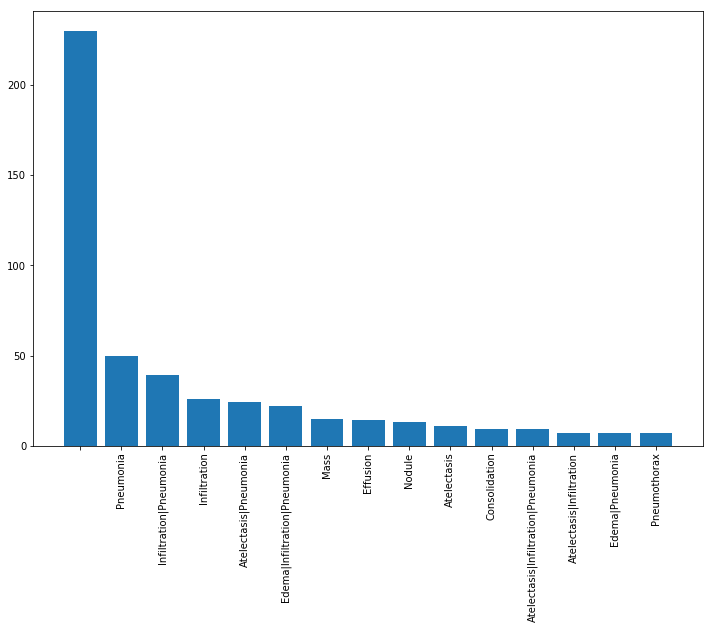

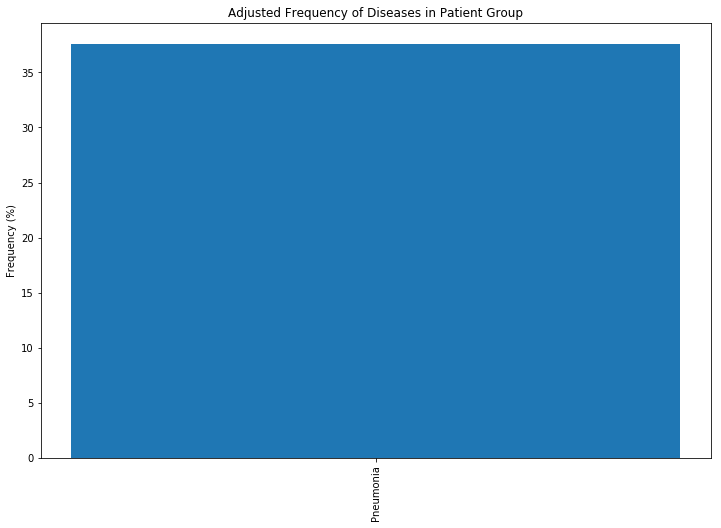

In [6]:
#CLEAN CaTEGORIES
# keep at least 1000 cases
MIN_CASES = 100
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])





# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(all_xray_df.shape[0], weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


print('allah')



label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [12]:
# Prepare Training Data
#all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


def _set_index_array(self):
        self.index_array = np.arange(self.n)
        if self.shuffle:
            self.index_array = np.random.permutation(self.n)


from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df.Pneumonia)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])







# Create Data Generators
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (139, 139)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)




def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen






train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'Pneumonia', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'Pneumonia', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'Pneumonia', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)) # one big batch



print("Lanndo")



train 480 validation 161
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 480 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 161 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 161 images
Lanndo


In [ ]:
t_x, t_y = next(train_gen)

# Create a simple model    
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = InceptionResNetV2(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

print("model.summary: ") 
multi_disease_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]





# First Round
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)



# Serialize model to JSON
from keras.models import model_from_json
model_json = multi_disease_model.to_json()
with open(r'pneumonia_model.json', "w") as json_file:
   json_file.write(model_json)

# Serialize weights to HDF5
#multi_disease_model.save_weights(r'pneumonia_model_weights.h5')
print("Saved model to disk")


# Check Output
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))
    
 



pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)    